In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import torch.nn.functional as F
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import copy
import random
import time


In [ ]:
ROOT = '.data'

mnist_data = dsets.MNIST(root=ROOT,
                            train=True,
                            download=True)
print(type(mnist_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

<class 'torchvision.datasets.mnist.MNIST'>


In [ ]:
train_dataset = dsets.CIFAR10(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.CIFAR10(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
print(type(train_dataset),type(test_dataset),len(train_dataset))
# print(train_dataset.shape,test_dataset.shape)

<class 'torchvision.datasets.cifar.CIFAR10'> <class 'torchvision.datasets.cifar.CIFAR10'> 50000


In [ ]:

# batch_size = 50
# n_iters = 10000
# num_epochs = n_iters / (len(train_dataset) / batch_size)
# num_epochs = int(num_epochs)

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False)
# print(num_epochs)

In [ ]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:

def plot_images(images,labels):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        # ax.imshow(images[i].view(32,32,3).cpu().numpy(), cmap='Greys')
        plt.imshow(images[i].permute((1, 2, 0)).cpu().numpy())
        plt.title(classes[labels[i]])
        ax.axis('off')

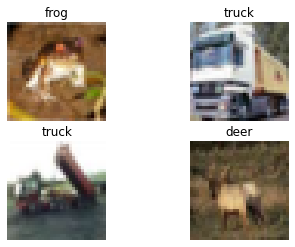

In [ ]:
#Visualizing Data in Matplotlib using train_dataset(downloaded data)
N_IMAGES = 5
images = [image for image, label in [train_dataset[i] for i in range(N_IMAGES)]]
labels = [label for image, label in [train_dataset[i] for i in range(N_IMAGES)]]
plot_images(images,labels)



In [ ]:
#Creating Validation Set
VALID_RATIO = 0.9

n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

In [ ]:
train_dataset, valid_dataset = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
batch_size = 50
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=batch_size)

valid_loader = data.DataLoader(valid_dataset,
                                 shuffle=False,
                                 batch_size=batch_size)

test_loader = data.DataLoader(test_dataset,
                                shuffle=False,
                                batch_size=batch_size)
print(num_epochs)

11


In [ ]:
# Visualizing Data in Matplotlib using train_loader(batch wise data)
# images, labels = next(iter(train_loader))
# # print(type(images),len(images),images[0].shape)
# upper_bound=0
# lower_bound=5
# plot_images(images[upper_bound:lower_bound],labels[upper_bound:lower_bound])

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3,output_dim):
    super(FeedforwardNeuralNetModel, self).__init__()
    # Linear function 1: 784 --> 100
    self.fc1 = nn.Linear(input_dim, hidden_dim1)
    # Non-linearity 1
    self.relu1 = nn.ReLU()

    # Linear function 2: 100 --> 100
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    # Non-linearity 2
    self.relu2 = nn.ReLU()

    # Linear function 3 : 100 --> 10
    self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
    self.relu3 = nn.ReLU()

    # Linear function 4 (readout): 100 --> 10
    self.fc4 = nn.Linear(hidden_dim3, output_dim)

  def forward(self, x):
    # Linear function 1
    out = self.fc1(x)
    # Non-linearity 1
    out = self.relu1(out)

    # Linear function 2
    out = self.fc2(out)
    # Non-linearity 2
    out = self.relu2(out)

    # Linear function 3
    out = self.fc3(out)
    # Non-linearity 3
    out = self.relu3(out)

    # Linear function 4 (readout)
    out = self.fc4(out)
    return out

In [ ]:
input_dim = 32*32*3
hidden_dim1 = 500
hidden_dim2=250
hidden_dim3=100

output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim1,hidden_dim2,hidden_dim3,output_dim)
# model = FeedforwardNeuralNetModelWithBN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3,output_dim)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,687,860 trainable parameters


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
#  This is used to place the model and data on to a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)



In [ ]:
print(model.parameters())

<generator object Module.parameters at 0x7f9057c71bd0>


In [ ]:
print(len(list(model.parameters())))
print(list(model.parameters())[0].size())
print(list(model.parameters())[1].size())
print(list(model.parameters())[2].size())
print(list(model.parameters())[3].size())


8
torch.Size([500, 3072])
torch.Size([500])
torch.Size([250, 500])
torch.Size([250])


In [ ]:

# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim=True)
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
#     return acc

In [ ]:
iter = 0
history_data=[]
for epoch in range(num_epochs):
    total_train_labels=0
    train_correct=0
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 32*32*3).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
        # print(outputs.shape,torch.argmax(labels),torch.argmin(labels),labels.shape)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        #  Get predictions from the maximum value
        _, train_predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total_train_labels += labels.size(0)

        # Total correct predictions
        train_correct += (train_predicted == labels).sum()


        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in valid_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 32*32*3).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)
                valid_loss = criterion(outputs, labels)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            valid_accuracy = 100 * correct / total
            train_accuracy = 100 * train_correct / total_train_labels
            # Print Loss

            # print('Iteration: {}. Valid_Loss: {}. Validation Accuracy: {}'.format(epoch, loss.item(), valid_accuracy))
            print('Validation Accuracy: {} Training Accuracy: {}'.format(valid_accuracy,train_accuracy))
            accuracy = 100 * train_correct / total_train_labels
            print('Validation Loss: {} Training Loss: {} '.format(valid_loss.item(),loss.item()))

            history_data.append([iter, loss.item(),valid_loss.item(),train_accuracy,valid_accuracy])
            print('__________________iter: {} completed____________'.format(iter))




Validation Accuracy: 29.860000610351562 Training Accuracy: 24.15999984741211
Validation Loss: 1.9502613544464111 Training Loss: 2.038405179977417 
__________________iter: 500 completed____________
Validation Accuracy: 36.119998931884766 Training Accuracy: 34.31999969482422
Validation Loss: 1.7511932849884033 Training Loss: 1.7637919187545776 
__________________iter: 1000 completed____________
Validation Accuracy: 36.099998474121094 Training Accuracy: 35.776668548583984
Validation Loss: 1.7945863008499146 Training Loss: 1.7597899436950684 
__________________iter: 1500 completed____________
Validation Accuracy: 38.900001525878906 Training Accuracy: 39.970001220703125
Validation Loss: 1.688510537147522 Training Loss: 1.815353274345398 
__________________iter: 2000 completed____________
Validation Accuracy: 41.34000015258789 Training Accuracy: 39.82857131958008
Validation Loss: 1.5678820610046387 Training Loss: 1.762773871421814 
__________________iter: 2500 completed____________
Validatio

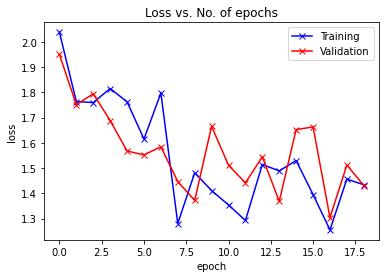

In [ ]:
train_losses = [x[1] for x in history_data]
val_losses = [x[2] for x in history_data]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

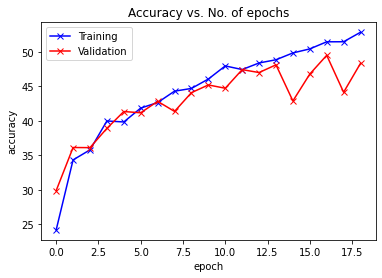

In [ ]:
train_accuracy = [x[3] for x in history_data]
val_accuracy = [x[4] for x in history_data]
plt.plot(train_accuracy, '-bx')
plt.plot(val_accuracy, '-rx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy vs. No. of epochs');

In [ ]:
    # # Validation_accuracies = [x['Accuracy'] for x in history_data]
    # Training_Accuracies = [x[3] for x in history_data]
    # plt.plot(Training_Accuracies, '-rx')
    # # plt.plot(Validation_accuracies, '-bx')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # # plt.legend(['Training', 'Validation'])
    # plt.title('Train Accuracy vs. No. of epochs');

In [ ]:
# Training_Loss = [x[1] for x in history_data]
# plt.plot(Training_Loss, '-rx')
# # plt.plot(Validation_accuracies, '-bx')
# plt.xlabel('epoch')
# plt.ylabel('Training_Loss')
# # plt.legend(['Training', 'Validation'])
# plt.title('Training_Loss vs. No. of epochs');

In [ ]:
# Valid_Accuracy = [x[4] for x in history_data]
# plt.plot(Valid_Accuracy, '-rx')
# # plt.plot(Validation_accuracies, '-bx')
# plt.xlabel('epoch')
# plt.ylabel('Valid_Accuracy')
# # plt.legend(['Training', 'Validation'])
# plt.title('Valid_Accuracy vs. No. of epochs');

In [ ]:
# Valid_Accuracy = [x[2] for x in history_data]
# plt.plot(Valid_Accuracy, '-rx')
# # plt.plot(Validation_accuracies, '-bx')
# plt.xlabel('epoch')
# plt.ylabel('Valid_Loss')
# # plt.legend(['Training', 'Validation'])
# plt.title('Valid_Loss vs. No. of epochs');

In [ ]:
def evaluate_model(data_loader):
  test_total=0
  test_correct=0
  for images, labels in data_loader:
      # Load images with gradient accumulation capabilities
      images = images.view(-1, 32*32*3).requires_grad_()

      # Forward pass only to get logits/output
      outputs = model(images)
      test_loss = criterion(outputs, labels)

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      # Total number of labels
      test_total += labels.size(0)

      # Total correct predictions
      test_correct += (predicted == labels).sum()

  test_accuracy = 100 * test_correct / test_total
  print('Test Accuracy: {} Test Loss : {}'.format(test_accuracy,test_loss))


In [ ]:
evaluate_model(test_loader)

Test Accuracy: 51.290000915527344 Test Loss : 1.5070713758468628


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (image, label) in iterator:
            imaged = image.view(-1, 32*32*3)
            imaged = imaged.to(device)

            y_pred = model(imaged)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs =get_predictions(model, test_loader, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

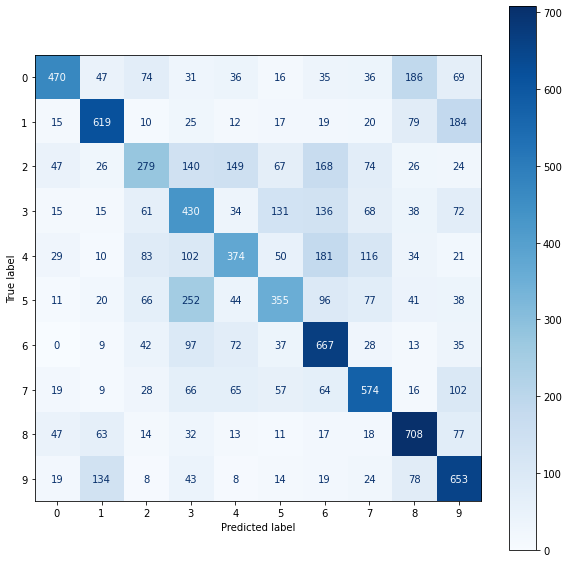

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        # print(image.shape)
        ax.imshow(image.permute((1, 2, 0)).cpu().numpy())
        ax.set_title(f'true label: {classes[true_label]} ({true_prob:.3f})\n'
                     f'pred label: {classes[incorrect_label]} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

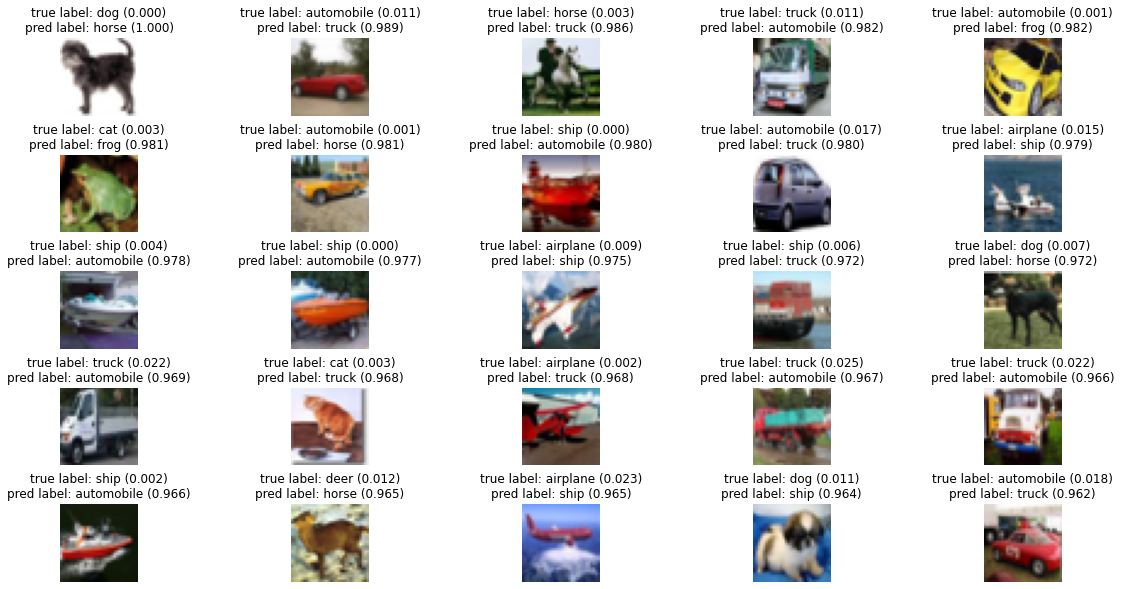

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)